In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import sklearn
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import seaborn as sns

%matplotlib inline

In [2]:
datas = pd.read_csv('sold_info.csv')


#split data
datas['postCode'] = datas['address'].map(lambda x: ' '.join(x.split(' ')[-2:]))
datas['houseType'] = datas['soldType'].map(lambda x: x.split(',')[0])
datas['residential'] = datas['soldType'].map(lambda x: x.split(',')[2])
datas['duration'] = datas['soldType'].map(lambda x: x.split(',')[1])

In [3]:
datas['bedrooms'] = datas['bedrooms'].str.extract('(\d+)')



In [4]:
datas['price'] = datas['price'].str.extract('([\d,]+)')

In [5]:
datas['price'] = datas['price'].map(lambda x: ''.join(x.split(',')))

In [6]:
datas['soldDate'] = datas['soldDate'].map(lambda x: datetime.strptime(x, '%d %b %Y'))

In [7]:
df1 = datas.drop(['soldType'], axis=1)
#drop null values
df = pd.DataFrame(df1.dropna(subset=['bedrooms']))

In [8]:
df.head()

,Unnamed: 0,address,bedrooms,city,price,soldDate,postCode,houseType,residential,duration
0,0,"1, Old Newbridge Hill, Bath, Bath And North Ea...",4,Bath,487000,2019-04-23,BA1 3LX,Semi-Detached,Residential,Freehold
3,3,"Orchard Leigh, Eden Villas, Bath, Bath And Nor...",4,Bath,483000,2019-04-17,BA1 6SH,Semi-Detached,Residential,Freehold
4,4,"5, Parry Close, Bath, Bath And North East Some...",2,Bath,285000,2019-04-16,BA2 1JR,Semi-Detached,Residential,Freehold
5,5,"10, Freeview Road, Bath, Bath And North East S...",2,Bath,250000,2019-04-15,BA2 1DR,Semi-Detached,Residential,Freehold
6,6,"18, Vernham Grove, Bath, Bath And North East S...",3,Bath,267000,2019-04-15,BA2 2TB,Terraced,Residential,Freehold


Text(0.5, 1.0, 'property sales trend')

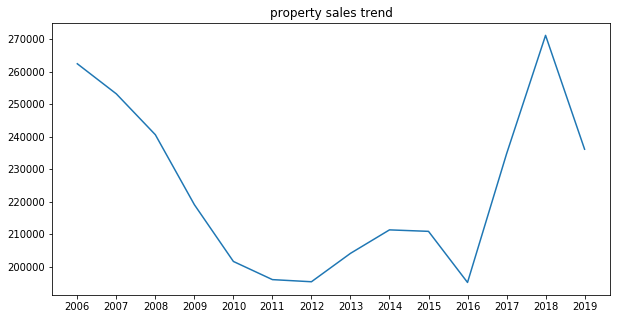

In [9]:
#analyze data:
##Let's check the average property sales trend
years = df['soldDate'].apply(lambda x: x.year).unique()
years
# df['price'] = df['price'].astype(int)
df.loc[:, ['price']] = df['price'].astype(int)
price = df['price'].groupby(df['soldDate'].apply(lambda x: x.year)).mean()
plt.subplots(figsize= (10, 5))

plt.plot(years, price)
plt.xticks(years)
plt.title('property sales trend')
##Conclusion:
#------looks strange and seems no help-----

In [10]:
#check the sold house qty by year
sold_qty = df['Unnamed: 0'].groupby(df['soldDate'].apply(lambda x: x.year)).count()
sold_qty

#conclution: increasing

soldDate
2006      15
2007      60
2008      41
2009     106
2010     152
2011     129
2012     153
2013     311
2014     681
2015    1038
2016    1760
2017    2751
2018    5360
2019    1547
Name: Unnamed: 0, dtype: int64

In [11]:
#checked the offical property price during last 10 years, no big changes, so I decide use data from 2011.
df_from_2011 = df[(df['soldDate']>='2011-01-01')]

In [12]:
#import postcode_lon_lat data
postcode_lon_lat = pd.read_csv('ukpostcodes.csv')
postcode_lon_lat.head()

,id,postcode,latitude,longitude
0,1,AB10 1XG,57.144165,-2.114848
1,2,AB10 6RN,57.137880,-2.121487
2,3,AB10 7JB,57.124274,-2.127190
3,4,AB11 5QN,57.142701,-2.093295
4,5,AB11 6UL,57.137547,-2.112233


In [13]:
#merge the lon and lat data on postcode
merge_df = pd.merge(df_from_2011, postcode_lon_lat,how = 'left', left_on = 'postCode',right_on =  'postcode')

In [14]:
merge_df.head()

,Unnamed: 0,address,bedrooms,city,price,soldDate,postCode,houseType,residential,duration,id,postcode,latitude,longitude
0,0,"1, Old Newbridge Hill, Bath, Bath And North Ea...",4,Bath,487000,2019-04-23,BA1 3LX,Semi-Detached,Residential,Freehold,1652513,BA1 3LX,51.389446,-2.401029
1,3,"Orchard Leigh, Eden Villas, Bath, Bath And Nor...",4,Bath,483000,2019-04-17,BA1 6SH,Semi-Detached,Residential,Freehold,1651917,BA1 6SH,51.398812,-2.345813
2,4,"5, Parry Close, Bath, Bath And North East Some...",2,Bath,285000,2019-04-16,BA2 1JR,Semi-Detached,Residential,Freehold,1645731,BA2 1JR,51.373936,-2.390162
3,5,"10, Freeview Road, Bath, Bath And North East S...",2,Bath,250000,2019-04-15,BA2 1DR,Semi-Detached,Residential,Freehold,1646114,BA2 1DR,51.379450,-2.397522
4,6,"18, Vernham Grove, Bath, Bath And North East S...",3,Bath,267000,2019-04-15,BA2 2TB,Terraced,Residential,Freehold,1645682,BA2 2TB,51.358799,-2.383168


Text(0.5, 1.0, 'price vs bedrooms')

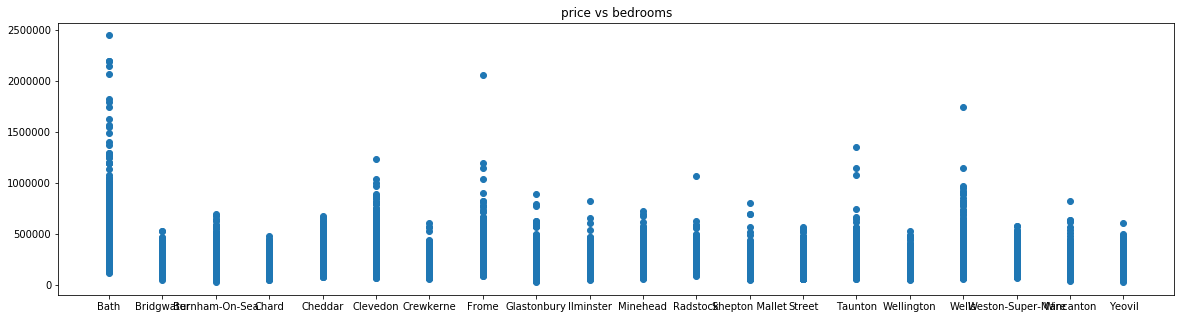

In [15]:
plt.figure(figsize=(20,5))
plt.scatter(merge_df['city'], merge_df['price'])
plt.title('price vs bedrooms')

In [16]:
# merge_df.to_csv('data.csv')

In [17]:
df_final = pd.DataFrame(merge_df[['bedrooms', 'price','houseType', 'residential', 'duration', 'latitude', 'longitude']])

In [18]:

#transform houseTypes: 'Semi-Detached':0, 'Terraced':1, 'Flat':2, 'Detached':3
df_final['houseType'].replace('Semi-Detached', 0, inplace=True)
df_final['houseType'].replace('Terraced', 1, inplace=True)
df_final['houseType'].replace('Flat', 2, inplace=True)
df_final['houseType'].replace('Detached', 3, inplace=True)

In [19]:
#transform residential:  Residential\xa0(New Build):1, ' Residential':0
df_final['residential'].unique()
df_final['residential'].replace(' Residential', 0, inplace=True)
df_final['residential'].replace(' Residential\xa0(New Build)', 1, inplace=True)

In [20]:
#transform duration:' Freehold':0, ' Leasehold':1
df_final['duration'].unique()
df_final['duration'].replace(' Freehold', 0, inplace=True)
df_final['duration'].replace(' Leasehold', 1, inplace=True)


In [21]:
df_final['duration'].unique()

array([0, 1], dtype=int64)

In [68]:
df_final

,bedrooms,price,houseType,residential,duration,latitude,longitude
0,4,487000,0,0,0,51.389446,-2.401029
1,4,483000,0,0,0,51.398812,-2.345813
2,2,285000,0,0,0,51.373936,-2.390162
3,2,250000,0,0,0,51.379450,-2.397522
4,3,267000,1,0,0,51.358799,-2.383168
5,3,252000,0,0,0,51.396581,-2.394206
6,2,170000,1,0,0,51.358799,-2.383168
7,3,340000,1,0,1,51.393020,-2.346114
8,2,301000,1,0,0,51.397892,-2.394793
9,2,290000,1,0,0,51.380642,-2.385304


In [23]:
df_final['bedrooms'] = df_final['bedrooms'].astype(int)

In [24]:
#export data to csv for future use.
df_final.to_csv('df_final.csv')

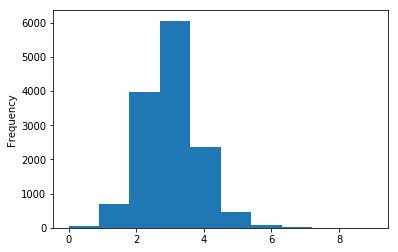

In [25]:
df_final['bedrooms'].plot.hist()

In [26]:
df_final['bedrooms'].value_counts()

3    6060
2    3980
4    2375
1     697
5     460
6      82
0      52
7      18
8       5
9       1
Name: bedrooms, dtype: int64

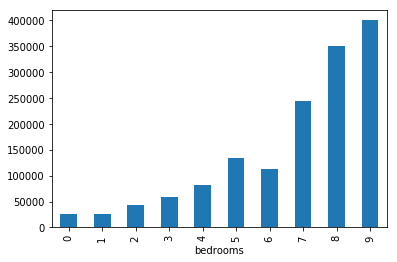

In [27]:
df_final.groupby(['bedrooms']).agg('min')['price'].plot.bar()

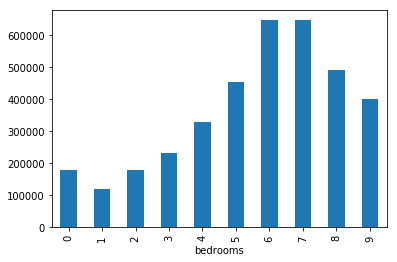

In [28]:
df_final.groupby(['bedrooms']).agg('mean')['price'].plot.bar()

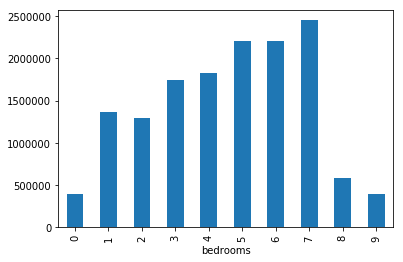

In [29]:
df_final.groupby(['bedrooms']).agg('max')['price'].plot.bar()

<function seaborn.utils.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)>

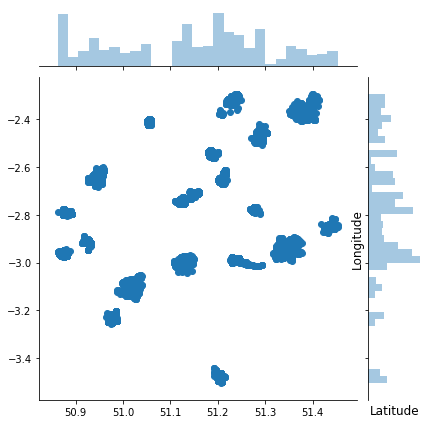

In [31]:
import seaborn as sns
# plt.figure(figsize=(10,10)
sns.jointplot(x=df_final.latitude.values, y=df_final.longitude.values)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show
sns.despine

Text(0.5, 1.0, 'price vs bedrooms')

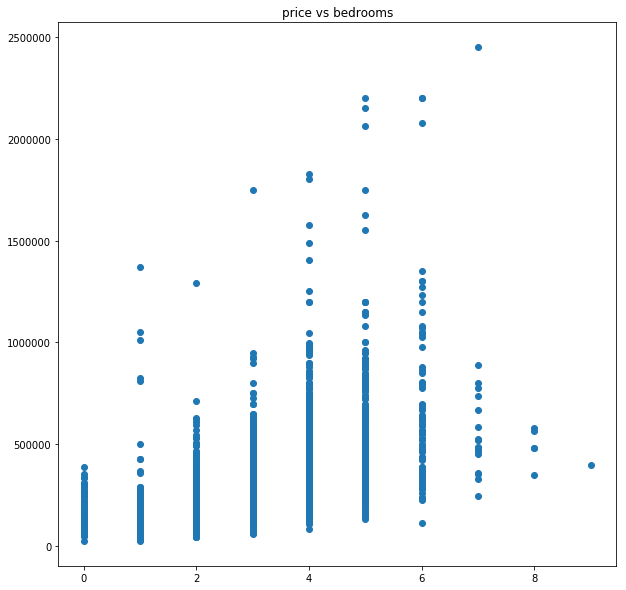

In [32]:
plt.figure(figsize=(10, 10))
plt.scatter(df_final['bedrooms'], df_final['price'])
plt.title('price vs bedrooms')

In [33]:
trains = df_final[['bedrooms', 'houseType', 'residential', 'duration', 'latitude', 'longitude']]
results = df_final['price']

In [34]:
def LinearRegression_tain( trains, results):
    lr = LinearRegression()
    lr.fit(trains, results)
    return lr

In [35]:
X_train, X_test, y_train, y_test = train_test_split(trains, results, test_size=0.25, random_state=42)

In [50]:
LR = LinearRegression_tain(X_train, y_train)
prediction_lr = LR.predict(X_test)


Text(0.5, 1.0, 'Prices vs Predicted Prices: LinearRegression')

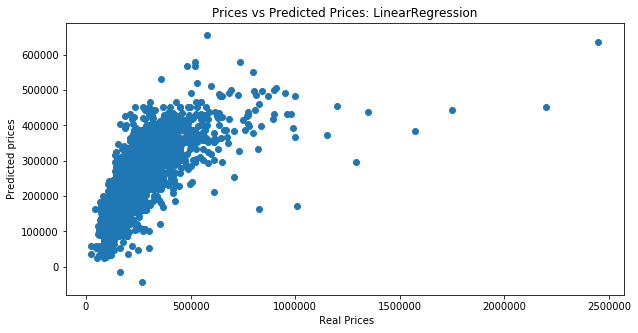

In [51]:
#check the difference between predictions and real value:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, prediction_lr)
plt.xlabel(" Real Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted Prices: LinearRegression")

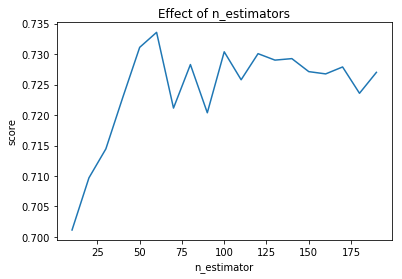

In [42]:
#find best n_estimators for RandomForestRegressor
model = RandomForestRegressor(n_jobs=-1)
estimators = np.arange(10, 200, 10)
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [39]:
def RandomForestRegressor_train(x, y):
    rfr = RandomForestRegressor()
    rfr.set_params(n_estimators = 70)
    rfr.fit(x, y)
    return rfr

In [46]:
#predict using RandomForestRegressor
model = RandomForestRegressor_train(X_train, y_train)
prediction = model.predict(X_test)
prediction

array([236057.14285714, 324085.71428571, 289532.85714286, ...,
       178840.68027211, 453735.71428571, 126821.07142857])

Text(0.5, 1.0, 'Prices vs Predicted Prices: RandomForestRegressor')

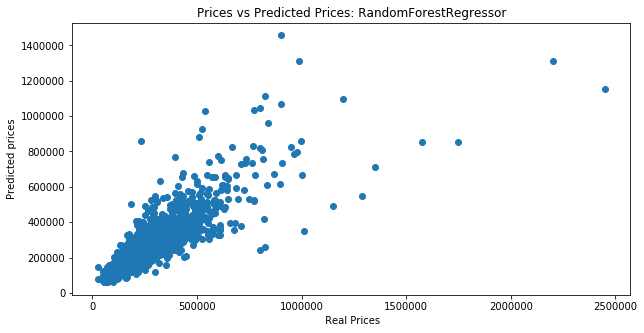

In [70]:
#Check the difference between prediction and real values:
plt.figure(figsize=(10, 5))
plt.scatter(y_test, prediction)
plt.xlabel(" Real Prices")
plt.ylabel("Predicted prices")
plt.title("Prices vs Predicted Prices: RandomForestRegressor")

#conclusion: RandomForestRegressor fits better than LinearRegression, so fininally i choose RandomForestRegressor

In [48]:
#MSE
def get_MSE(prediction, y_test):
    m = 0
    n = len(prediction)
    for i in range(n):
        m += (prediction[i] - y_test.values[i])**2
    MSE = m/len(prediction)
    return MSE

In [71]:
import math

In [76]:
#MSE for randomforestregressor
NMSE = math.sqrt(get_MSE(prediction, y_test))
NMSE

71807.79560098224

In [77]:
#MSE for LinearRegression
NMSE = math.sqrt(get_MSE(prediction_lr, y_test))
NMSE

100734.24207600283